## SVM

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# creating Iris Virginica classifier (yes or no)
iris = load_iris()
X = iris["data"][:, (2,3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

,steps,"[('scaler', ...), ('linear_svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001


In [4]:
svm_clf.predict([[5.5, 1.7]])


array([1.])

Alternatively, you could use the SVC class, using SVC(kernel="linear", C=1), but it
 is much slower, especially with large training sets, so it is not recommended. Another
 option is to use the SGDClassifier class, with SGDClassifier(loss="hinge",
 alpha=1/(m*C)). This applies regular Stochastic Gradient Descent (see Chapter 4) to
 train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it
 can be useful to handle huge datasets that do not fit in memory (out-of-core train
ing), or to handle online classification tasks.

In [5]:
# not recommended
from sklearn.svm import SVC
svc_linear_clf = SVC(kernel="linear", C=1)




In [6]:
# SGD Classifier
# to handle huge datasets
# from sklearn.linear_model import SGDClassifier

# sgd_svm_clf = SGDClassifier(loss="hinge", alpha=1/(m*C))

### Non linear SVM classification

You can add features (like convert a dataset with one feature, which is not linearly seperable, but if you add a second features (polynomial scalling), resultant may become lineraly seperable)

To implement this idea using Scikit-Learn, you can create a Pipeline containing a
 PolynomialFeatures transformer (discussed in “Polynomial Regression” on page
 123), followed by a StandardScaler and a LinearSVC. Let’s test this on the moons
 dataset 

In [7]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features",  PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(loss="hinge", C=10, max_iter=10000) ) # lowers street width

 ])

X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
polynomial_svm_clf.fit(X, y)

,steps,"[('poly_features', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,True
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [8]:
moons = make_moons()

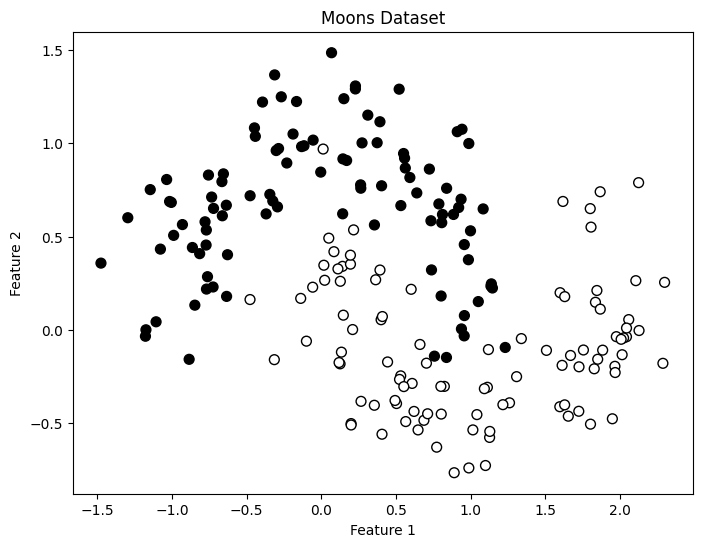

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='grey', edgecolor='k', s=50)
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Polynomial Kernel

 Fortunately, when using SVMs you can apply an almost miraculous mathematical
 technique called the kernel trick (it is explained in a moment). It makes it possible to
 get the same result as if you added many polynomial features, even with very high
degree polynomials, without actually having to add them

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)) # implementing polynomial kernel
])
poly_kernel_svm_clf.fit(X, y)

,steps,"[('scaler', ...), ('svm_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [ ]:
# from sklearn.metrics import classification_report 

In [ ]:
# finding best hyperparameteres using Gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'degree': [1, 2, 3, 4, 5, 6],
			'kernel': ['poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(X, y)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'degree': [1, 2, ...], 'gamma': [1, 0.1, ...], 'kernel': ['poly']}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,C,1


In [25]:
grid_search.best_params_

{'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}

###  Gaussian RBF Kernel

 Equation 5-1. Gaussian RBF
 ϕ(x,ℓ) = exp (−γ∥ x−ℓ ∥^2)
 It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at
 the landmark). Now we are ready to compute the new features.

Just like the polynomial features method, the similarity features method can be useful
 with any Machine Learning algorithm, but it may be computationally expensive to
 compute all the additional features, especially on large training sets. However, once
 again the kernel trick does its SVM magic: it makes it possible to obtain a similar
 result as if you had added many similarity features, without actually having to add
 them. 

In [26]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)



,steps,"[('scaler', ...), ('svm_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,0.001
,kernel,'rbf'
,degree,3
,gamma,5


 Increasing
 gamma makes the bell-shape curve narrower (see the left plot of Figure 5-8), and as a
 result each instance’s range of influence is smaller: the decision boundary ends up
 being more irregular, wiggling around individual instances

Conversely, a small gamma 
value makes the bell-shaped curve wider, so instances have a larger range of influ
154 
| 
Chapter 5: Support Vector Machines
ence, and the decision boundary ends up smoother. So γ acts like a regularization
 hyperparameter: if your model is overfitting, you should reduce it, and if it is under
fitting, you should increase it (similar to the C hyperparameter)

# PRO TIP

 With so many kernels to choose from, how can you decide which
 one to use? As a rule of thumb, you should always try the linear
 kernel first (remember that LinearSVC is much faster than SVC(ker
 nel="linear")), especially if the training set is very large or if it
 has plenty of features. If the training set is not too large, you should
 try the Gaussian RBF kernel as well; it works well in most cases.
 Then if you have spare time and computing power, you can also
 experiment with a few other kernels using cross-validation and grid
 search, especially if there are kernels specialized for your training
 set’s data structure

##### important why Linear SVC is faster than SVC(kernel="linear")
 The LinearSVC class is based on the liblinear library, which implements an optimized
 algorithm for linear SVMs.1 It does not support the kernel trick, but it scales almost
 linearly with the number of training instances and the number of features: its training
 time complexity is roughly O (m * n)

  The SVC class is based on the libsvm library, which implements an algorithm that sup
ports the kernel trick.2 The training time complexity is usually between O(m2 × n)
 and O(m3 × n). Unfortunately, this means that it gets dreadfully slow when the num
ber of training instances gets large (e.g., hundreds of thousands of instances).

![alt text](svm.jpg "Title")

### SVM REGRESSION

The trick is to reverse the objective: instead of trying to fit the largest pos
sible street between two classes while limiting margin violations, SVM Regression
 tries to fit as many instances as possible on the street while limiting margin violations
 (i.e., instances off the street)

 The width of the street is controlled by a hyperparame
ter ϵ. Figure 5-10 shows two linear SVM Regression models trained on some random
 linear data, one with a large margin (ϵ = 1.5) and the other with a small margin (ϵ =
 0.5)
![alt text](image.png "Title")
 